In [1]:
from glob import iglob
from functools import reduce, partial
from itertools import combinations

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import udf, size, col, lit, explode
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType, ArrayType
import matplotlib.pyplot as plt
from numpy import linspace, histogram, histogram2d, array
from numba import jit

Connect to Spark master

In [2]:
builder = (SparkSession
           .builder
           .appName("PySpark Example")
           .master("spark://carbon.uedalab.local:7077")
           .config("spark.jars.packages", "org.diana-hep:spark-root_2.11:0.1.15")
           .config("spark.cores.max", 11)
           .config("spark.executor.cores", 5)
           .config("spark.executor.memory", "4g")
           )
spark = builder.getOrCreate()

Read root files

In [5]:
globbed = iglob("/Volumes/analysis/saito/SortEvent_aq002_t100_b.root")
roots = (spark
         .read
         .format("org.dianahep.sparkroot")
         .load(fn) for fn in globbed)
df = reduce(DataFrame.unionAll, roots)
df.printSchema()

root
 |-- SortedEvent: struct (nullable = true)
 |    |-- fEventID: long (nullable = true)
 |    |-- fDetektors: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- fDetektors_fHits: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |-- fPDNbr: integer (nullable = true)
 |    |    |    |    |    |-- fHitNbr: integer (nullable = true)
 |    |    |    |    |    |-- fU1Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fU2Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fV1Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fV2Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fW1Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fW2Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fMcpNbr: integer (nullable = true)
 |    |    |    |    |    |-- fX_mm: double (nullable = true)
 |    |    |    |    |    |-- fY_mm: double (

Restruct

In [6]:
HitType = StructType([
    StructField('x', DoubleType(), nullable=False),
    StructField('y', DoubleType(), nullable=False),
    StructField('t', DoubleType(), nullable=False),
    StructField('flag', IntegerType(), nullable=False)])


@udf(ArrayType(HitType))
def combine_hits(xarr, yarr, tarr, flagarr):
    return [{'x': x,
             'y': y,
             't': t,
             'flag': f
            } for x, y, t, f in zip(xarr, yarr, tarr, flagarr)]


chits = col('SortedEvent.fDetektors').getItem(0).getField('fDetektors_fHits')
restructed = (df
              .withColumn('hits', combine_hits(chits.getField('fX_mm'),
                                               chits.getField('fY_mm'),
                                               chits.getField('fTime'),
                                               chits.getField('fRekmeth')))
              .select(col('SortedEvent.fEventID').alias("tag"), 'hits'))
restructed.printSchema()

root
 |-- tag: long (nullable = true)
 |-- hits: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- x: double (nullable = false)
 |    |    |-- y: double (nullable = false)
 |    |    |-- t: double (nullable = false)
 |    |    |-- flag: integer (nullable = false)



# PIPICO

Load data on Memory

In [7]:
@udf(ArrayType(ArrayType(DoubleType())))
def combinate_tofs(tarr, n):
    return list(combinations(tarr, n))


loaded = (restructed
          .select(explode(combinate_tofs('hits.t', lit(2))).alias('couple'))
          .select(col('couple').getItem(0).alias('t0'), col('couple').getItem(1).alias('t1'))
          .limit(1000000)
          .toPandas())
loaded.head()

,t0,t1
0,2155.871475,2924.695993
1,2155.871475,2995.360237
2,2924.695993,2995.360237
3,873.481186,1037.130562
4,873.481186,2106.438661


Estimate PIPICO

In [10]:
hist, xedges, yedges = histogram2d(
    loaded['t0'], loaded['t1'],
    bins=(500, 500),
    range=((2000, 4000), (2000, 4000)))
bg = 2*hist.sum(1)[:, None]@hist.sum(0)[None, :]/hist.sum()

Plot

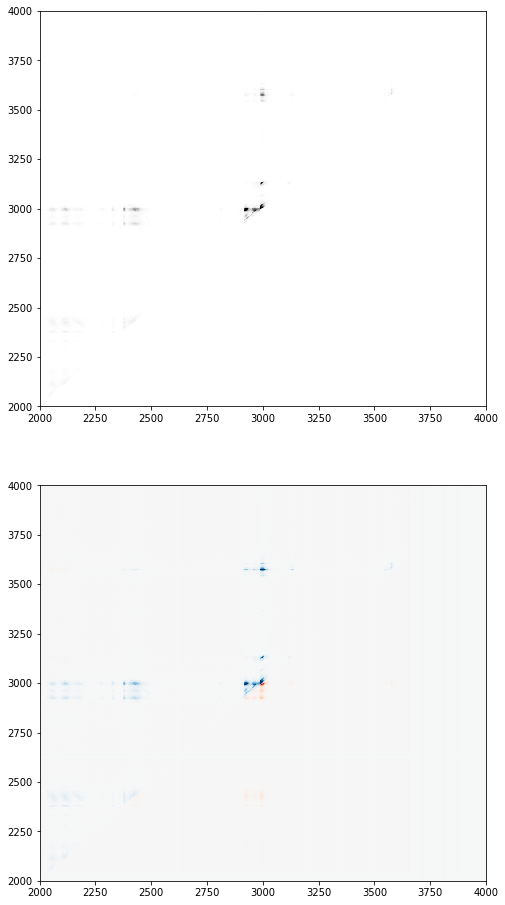

In [11]:
f = 0.3
clim = 500

plt.figure(figsize=(8, 16))
plt.subplot(211)
plt.pcolormesh(xedges, yedges, (hist - f*bg).T, cmap='Greys')
plt.clim(0, clim)
# plt.colorbar()

plt.subplot(212)
plt.pcolormesh(xedges, yedges, (hist - f*bg).T, cmap='RdBu')
plt.clim(-clim, clim)
plt.show()

In [13]:
spark.stop()